In [ ]:
#
# The MIT License (MIT)

# Copyright (c) 2021, NVIDIA CORPORATION

# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
#

## Library packages

In [1]:
import  pandas as pd 
import numpy as np
import xgboost as xgb
import argparse
import os 
import json
import random
import time

from sigir_ecom_challenge_code.evaluation_sigir import cart_abandonment_metric
from sigir_ecom_challenge_code.submission.uploader import upload_submission

import sklearn.metrics as metrics
import matplotlib.pyplot as plt 

import yaml 
import glob
from sklearn.metrics import f1_score


In [2]:
# Function for display dataframe info quickly
def di(df, rows=5):
    display(df.shape)
    display(df.head(rows))

# Function for get evaluation score for different nb_after_add and threshold
def eval_df(df, nb_after_add=0.0, threshold=0.5, full=False):
    if full:
        c_df = df
        preds = (c_df['predictions'].values > threshold).reshape(-1).astype(int).tolist()
        y_valid = c_df['is_purchased-last'].values
        nb_after_add = c_df['nb_after_add'].values
    else:
        c_df = df[df['nb_after_add']==nb_after_add].reset_index(drop=True)
        preds = (c_df['predictions'].values > threshold).reshape(-1).astype(int).tolist()
        y_valid = c_df['is_purchased-last'].values
        nb_after_add = c_df['nb_after_add'].values
    return preds, y_valid, nb_after_add

# Function for get evaluation score for different nb_after_add and threshold
def eval_df_micro(df, nb_after_add=0.0, threshold=0.5):
    c_df = df[df['nb_after_add']==nb_after_add].reset_index(drop=True)
    preds = (c_df['predictions'].values > threshold).reshape(-1).astype(int).tolist()
    y_valid = c_df['is_purchased-last'].values
    nb_after_add = c_df['nb_after_add'].values
    return f1_score(y_valid, preds, average='micro')
    


### Data paths

In [3]:
Data_PATH = '/raid/SIGIR-ecom-data-challenge/data/coveo_task2_v3_balanced_phase2/xgboost_data'
valid_PATH = 'product_TE_oof_v4/bag_1'


### Test and Valid preds loading

In [4]:
# test_preds = pd.read_parquet(Test_Valid_PATH+'test_predictions.parquet')
# valid_preds = pd.read_parquet(Test_Valid_PATH+'valid_predictions.parquet')
valid_files = []
for fold in range(1,6):
    VALID_PARQUET_FILE = os.path.join(valid_PATH, f"fold_{fold}/valid_predictions.parquet")
    valid_files.append(VALID_PARQUET_FILE)
#     VALID_PARQUET_FILE = os.path.join(Data_PATH_10, f"fold_{fold}/valid_predictions.parquet")
#     valid_files.append(VALID_PARQUET_FILE)
print(valid_files)
valid_preds = pd.concat([pd.read_parquet(file) for file in valid_files])
valid_preds = valid_preds.reset_index().drop(columns=['index'])

['product_TE_oof_v4/bag_1/fold_1/valid_predictions.parquet', 'product_TE_oof_v4/bag_1/fold_2/valid_predictions.parquet', 'product_TE_oof_v4/bag_1/fold_3/valid_predictions.parquet', 'product_TE_oof_v4/bag_1/fold_4/valid_predictions.parquet', 'product_TE_oof_v4/bag_1/fold_5/valid_predictions.parquet']


### Loading Training files

In [5]:
files = glob.glob(Data_PATH+'/*')
c_df = []
for f in files:
    if 'train' in f:
        print(f)
        c_df.append(pd.read_parquet(f))

train = pd.concat(c_df).reset_index(drop=True)

/raid/SIGIR-ecom-data-challenge/data/coveo_task2_v3_balanced_phase2/xgboost_data/train-5.parquet
/raid/SIGIR-ecom-data-challenge/data/coveo_task2_v3_balanced_phase2/xgboost_data/train-2.parquet
/raid/SIGIR-ecom-data-challenge/data/coveo_task2_v3_balanced_phase2/xgboost_data/train-4.parquet
/raid/SIGIR-ecom-data-challenge/data/coveo_task2_v3_balanced_phase2/xgboost_data/train-3.parquet
/raid/SIGIR-ecom-data-challenge/data/coveo_task2_v3_balanced_phase2/xgboost_data/train-1.parquet


### Loading validation files

In [6]:
files = glob.glob(Data_PATH+'/*')
c_df = []
for f in files:
    if 'valid' in f:
        print(f)
        c_df.append(pd.read_parquet(f))

valid = pd.concat(c_df).reset_index(drop=True)

    

/raid/SIGIR-ecom-data-challenge/data/coveo_task2_v3_balanced_phase2/xgboost_data/valid-2.parquet
/raid/SIGIR-ecom-data-challenge/data/coveo_task2_v3_balanced_phase2/xgboost_data/valid-5.parquet
/raid/SIGIR-ecom-data-challenge/data/coveo_task2_v3_balanced_phase2/xgboost_data/valid-3.parquet
/raid/SIGIR-ecom-data-challenge/data/coveo_task2_v3_balanced_phase2/xgboost_data/valid-1.parquet
/raid/SIGIR-ecom-data-challenge/data/coveo_task2_v3_balanced_phase2/xgboost_data/valid-4.parquet


In [7]:
# Brif info for validation data
di(valid)

(40011, 54)

,session_id_hash,product_url_id_list-0,product_url_id_list-1,product_url_id_list-2,product_url_id_list-3,product_url_id_list-4,event_type_list-0,event_type_list-1,event_type_list-2,event_type_list-3,...,mean_sim_desc,std_sim_desc,mean_sim_img,std_sim_img,is_purchased-last,nb_after_add-last,is_test-last,is_valid,fold,original_session_id_hash
0,74231,2018,139926.0,129093.0,183191.0,70044.0,2,1.0,2.0,2.0,...,0.008503,0.008503,0.106506,0.106506,0,10.0,0,1,2,487b98527cdc0bb7dd43c4d24778b7092cbef7fdd98592...
1,50294,41866,7887.0,170034.0,170034.0,41866.0,2,2.0,2.0,2.0,...,0.002026,0.002026,0.053251,0.053251,1,6.0,0,1,2,3105c63a8cd74d3d4660a5752ca33a2f20a6ada0596866...
2,44546,41866,37066.0,41866.0,19647.0,19647.0,2,2.0,1.0,2.0,...,0.000000,0.000000,0.000000,0.000000,1,0.0,0,1,2,2b6a138c971e729d0d4c1438357fdd63136f51d31b9f31...
3,44565,161670,12178.0,49231.0,98881.0,98881.0,2,2.0,2.0,2.0,...,0.000000,0.000000,0.000000,0.000000,1,0.0,0,1,2,2b6ecd3cb42daaeef500b1db6ea473acc6cdf987fcc0d5...
4,44572,164229,161347.0,164229.0,7887.0,166050.0,1,2.0,1.0,2.0,...,0.000000,0.000000,0.000000,0.000000,1,2.0,0,1,2,2b701e4d413036c25fdd3cd9f552682b632c9df4723dfc...


In [9]:
# Mergng validation data and validation predictions
merged_valid = valid_preds.set_index('session_id_hash').merge(valid.set_index('original_session_id_hash'), left_index=True, right_index=True).reset_index().rename(columns={"index": "session_id_hash"})
di(merged_valid,10)


(40011, 56)

,session_id_hash,nb_after_add,predictions,session_id_hash,product_url_id_list-0,product_url_id_list-1,product_url_id_list-2,product_url_id_list-3,product_url_id_list-4,event_type_list-0,...,nb_queries,mean_sim_desc,std_sim_desc,mean_sim_img,std_sim_img,is_purchased-last,nb_after_add-last,is_test-last,is_valid,fold
0,4877ed95bd18d3532087420af5fd1271b76bb2b00cc8aa...,2.0,0.236012,74210,48385,121132.0,51157.0,7887.0,41996.0,2,...,1.0,0.000000,0.000000,0.169598,0.120713,0,2.0,0,1,1
1,2b6e19be4b66083317342305ebaf4ffcc815c2336e7416...,0.0,0.127756,44561,141311,121371.0,106832.0,69222.0,106832.0,1,...,0.0,0.000000,0.000000,0.081926,0.081926,0,0.0,0,1,1
2,59b0ca78ae2e97fbaa4c2f0116e444ecb4ddcbad3a620b...,10.0,0.145501,92047,60667,178043.0,60667.0,60667.0,179219.0,2,...,2.0,0.515828,0.515828,0.338986,0.338986,0,10.0,0,1,1
3,2902efc81cc2415e9489b9ed5f3ec1e8c79e588974eceb...,10.0,0.108165,42134,148370,148370.0,148370.0,7601.0,141521.0,2,...,0.0,0.023210,0.023210,0.074210,0.074210,1,10.0,0,1,1
4,1971989254669d986313783dfa0c215739d117417a4cf3...,2.0,0.240763,26342,23756,23756.0,41866.0,52662.0,0.0,1,...,0.0,0.000000,0.000000,0.000000,0.000000,0,2.0,0,1,1
5,3c030b4cd903023cc560a50ec8e4ec2d569f3489a8e2c2...,8.0,0.585378,61516,7887,170034.0,170034.0,170034.0,170034.0,2,...,3.0,0.131522,0.244011,0.000000,0.000000,0,8.0,0,1,1
6,58aaa169322033b7c22bcde8a4e56144ae11fc87c509b6...,10.0,0.157797,90984,108046,119743.0,102913.0,94880.0,74542.0,2,...,0.0,0.384626,0.384626,0.000000,0.000000,0,10.0,0,1,1
7,0797a2e8e8ce1127599d2c380c709cbe9e68c87df666a7...,10.0,0.121914,7914,101902,91990.0,180781.0,9200.0,180781.0,2,...,2.0,0.182399,0.138615,0.000000,0.000000,1,10.0,0,1,1
8,0ed0754e2941fe6943f6c24c4a946b46b6df1ade240ba9...,4.0,0.655903,15390,141521,7887.0,21879.0,41866.0,7887.0,1,...,1.0,0.000000,0.000000,0.000000,0.000000,1,4.0,0,1,1
9,4bd0b257240a0ace17614bf15c5eb745b5047b206785ac...,0.0,0.091643,77676,169624,180724.0,32755.0,180724.0,180724.0,2,...,0.0,0.426550,0.426550,0.308411,0.308411,0,0.0,0,1,1


## Checking scores for different threshold and nb_after_add

<b>Validation score for 0.5 and 10 (all 0 )threshold and all nb_after_add</b>
<li>Best Score for 0.5 threshold 3.866</li>

In [11]:
threshold = 0.5
print('Threshold | Score')
print('------------------------------------------')
for threshold in np.linspace(0.2,1.0,9):
    preds = (merged_valid['predictions'].values > threshold).reshape(-1).astype(int).tolist()
    labels = merged_valid['is_purchased-last'].values
    nb_after_add = merged_valid['nb_after_add'].values
    sc = cart_abandonment_metric(preds, labels, nb_after_add)
    print('%11r  |  %4r    ' %(round(threshold,2), sc))
    print()

Threshold | Score
------------------------------------------
        0.2  |  3.361730778706684    

        0.3  |  3.7263096799277875    

        0.4  |  3.840840753527171    

        0.5  |  3.866264700918063    

        0.6  |  3.8171904551955356    

        0.7  |  3.783360625214455    

        0.8  |  3.7688950509389247    

        0.9  |  3.6443572772170887    

        1.0  |  3.5878350463825606    



<b>Finding validation score different nb_after_add with same threshold</b>

In [20]:
scores = []
for threshold in np.linspace(0.3,0.7,5):
    print("threshold:", round(threshold,2))
    print('nb_after_add | Score')
    print('------------------------------------------')
    score = []
    for val in np.unique(merged_valid['nb_after_add'].values):
        score.append(eval_df_micro(merged_valid, val, threshold))
        print('%11r  |  %4r    ' %(val, eval_df_micro(merged_valid, val, threshold)))
#         print('%11r  |  %4r    ' %(val, cart_abandonment_metric(*eval_df(merged_valid, val, threshold))))
    print()

    scores.append(score)

threshold: 0.3
nb_after_add | Score
------------------------------------------
        0.0  |  0.8519484390134864    
        2.0  |  0.8178519593613933    
        4.0  |  0.8516833484986351    
        6.0  |  0.8284077201447527    
        8.0  |  0.8307751343054489    
       10.0  |  0.757194628011085    

threshold: 0.4
nb_after_add | Score
------------------------------------------
        0.0  |  0.8546308024737351    
        2.0  |  0.8380261248185775    
        4.0  |  0.8748862602365787    
        6.0  |  0.8848009650180941    
        8.0  |  0.8691481197237145    
       10.0  |  0.782455766361117    

threshold: 0.5
nb_after_add | Score
------------------------------------------
        0.0  |  0.8542582519931451    
        2.0  |  0.8502177068214805    
        4.0  |  0.8830755232029117    
        6.0  |  0.8926417370325693    
        8.0  |  0.8718342287029931    
       10.0  |  0.7848006821573226    

threshold: 0.6
nb_after_add | Score
------------------------

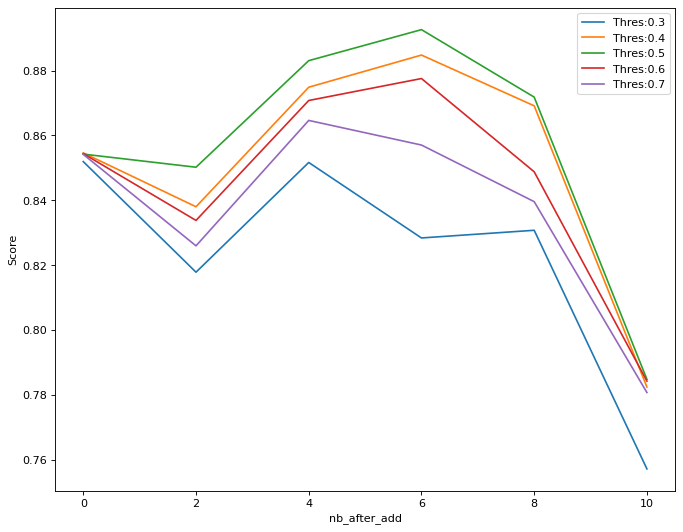

In [21]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)
x = np.unique(merged_valid['nb_after_add'].values)
thresholds = np.linspace(0.3,0.7,5)
i = 0
for score in scores:
    plt.plot(x, score, label="Thres:"+str(round(thresholds[i],2)))
    i+=1
plt.legend(loc="upper right")
plt.xlabel('nb_after_add')
plt.ylabel('Score') 
plt.show()

<b>Finding validation score different threshold for same nb_after_add</b>

In [22]:
scores = []
thres_values = np.linspace(0.3,0.7,5)
for val in np.unique(merged_valid['nb_after_add'].values):
    print("nb_after_add:", val)
    print('Threshold | Score')
    print('------------------------------------------')
    score = []
    for threshold in thres_values:
        sc = eval_df_micro(merged_valid, val, threshold)
        score.append(sc)
        print('%11r  |  %4r    ' %(round(threshold,2), sc))
    print()
    scores.append(score)

nb_after_add: 0.0
Threshold | Score
------------------------------------------
        0.3  |  0.8519484390134864    
        0.4  |  0.8546308024737351    
        0.5  |  0.8542582519931451    
        0.6  |  0.8544072721853812    
        0.7  |  0.8541837418970271    

nb_after_add: 2.0
Threshold | Score
------------------------------------------
        0.3  |  0.8178519593613933    
        0.4  |  0.8380261248185775    
        0.5  |  0.8502177068214805    
        0.6  |  0.8338171262699564    
        0.7  |  0.8259796806966618    

nb_after_add: 4.0
Threshold | Score
------------------------------------------
        0.3  |  0.8516833484986351    
        0.4  |  0.8748862602365787    
        0.5  |  0.8830755232029117    
        0.6  |  0.8707916287534121    
        0.7  |  0.8646496815286624    

nb_after_add: 6.0
Threshold | Score
------------------------------------------
        0.3  |  0.8284077201447527    
        0.4  |  0.8848009650180941    
        0.5  |  0.

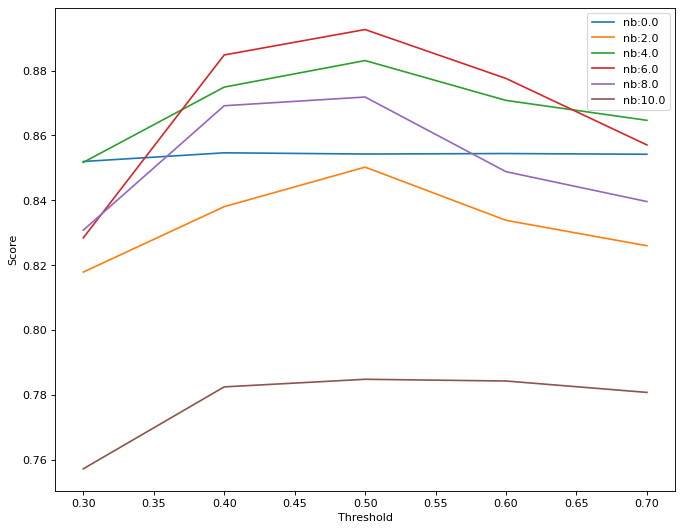

In [23]:
figure(figsize=(10, 8), dpi=80)
x = np.linspace(0.3,0.7,5)
nb_after_add = np.unique(merged_valid['nb_after_add'].values)
i = 0
for score in scores:
    plt.plot(x, score, label="nb:"+str(nb_after_add[i]))
    i+=1
plt.legend(loc="upper right")
plt.xlabel('Threshold')
plt.ylabel('Score') 
plt.show()

In [24]:
print('nb_after_add |    Rows    |    Purchased')
print('------------------------------------------')
for val in np.unique(merged_valid['nb_after_add'].values):
    c_df = merged_valid[merged_valid['nb_after_add']==val].reset_index(drop=True)
    print('%4r         |    %4r    |    %4r' %(val, c_df.shape[0], c_df[c_df['is_purchased-last']==1].shape[0]))
    print()


nb_after_add |    Rows    |    Purchased
------------------------------------------
 0.0         |    13421    |    1980

 2.0         |    6890    |    1740

 4.0         |    4396    |     838

 6.0         |    3316    |     654

 8.0         |    2606    |     577

10.0         |    9382    |    2138



In [25]:
print('nb_after_add |    Rows    |    Purchased')
print('------------------------------------------')
for val in np.unique(train['nb_after_add-last'].values):
    c_df = train[train['nb_after_add-last']==val].reset_index(drop=True)
    print('%4r         |    %4r    |    %4r' %(val, c_df.shape[0], c_df[c_df['is_purchased-last']==1].shape[0]))
    print()


nb_after_add |    Rows    |    Purchased
------------------------------------------
 0.0         |    29902    |    2513

 2.0         |    28138    |    7504

 4.0         |    17265    |    3273

 6.0         |    13519    |    2842

 8.0         |    11336    |    2705

10.0         |    74407    |    19268



<b>Comments</b>
<li>Clearly this version is performing better for all of the nb_after_add compared to the resampled one to mimick the testset</li>
<li>However, althouth validation is better the lb might not.</li>
